In [21]:
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
import spacy
from keras.models import Sequential
from sklearn.utils.class_weight import compute_class_weight
from keras.layers import Dense, Embedding, LSTM, Dropout, MaxPooling1D, Conv1D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
from spacy import displacy
import nltk
from keras.datasets import imdb
import tensorflow as tf
from keras.preprocessing import text
from nltk.parse.dependencygraph import DependencyGraph
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
import imdbb
import os
import pickle

In [22]:
stemmer = SnowballStemmer('english')

In [23]:
class Tweet:
    def __init__(self, count, hate_speech_count, offensive_language_count, neither_count, classs, tweet):
        """
        - count (int): The total count of the tweet.
        - hate (int): The count of hate speech in the tweet.
        - offensive (int): The count of offensive language in the tweet.
        - neither (int): The count of content classified as neither hate speech nor offensive.
        - classs (str): The classification of the tweet.
        - tweet (str): The text content of the tweet.
        """
        self.count = count
        self.hate = hate_speech_count
        self.offensive = offensive_language_count
        self.neither = neither_count
        self.classs = classs
        self.tweet = tweet
        self.stems = []
        self.tokens = []
        self.code = []
        self.tags = []
        self.t_code = []
        self.presence_word = []

    def __str__(self):
        return f"{self.count} ; {self.hate} ; {self.offensive} ; {self.neither} ; {self.classs} ;; {self.tweet}"
    
    def peacefullness(self):
        return self.neither_count / self.count
    
    def offensiveness(self):
        return self.offensive / self.count
    
    def hateness(self):
        return self.hate / self.count

In [24]:
Tweets = []

with open('./archive/train.csv', 'r+') as file:
    previous_line = ''

    # Initialize a list to accumulate the modified content
    final_content_lines = []

    # Read and accumulate non-empty lines
    for line in file:
        stripped_line = line.strip()

        if stripped_line and stripped_line[0].isdigit():
            # If the current line is not empty and starts with an integer, accumulate it
            final_content_lines.append(stripped_line)
            previous_line = stripped_line
        else:
            # If the current line doesn't start with an integer, append it to the previous line
            previous_line += stripped_line

In [25]:
for line in final_content_lines:
    
    comma_indices = [index for index, char in enumerate(line) if char == ',']

    # Extracting substrings between commas
    count_str = line[0:comma_indices[0]].strip()
    hate_str = line[comma_indices[0]+1:comma_indices[1]].strip()
    offensive_str = line[comma_indices[1]+1:comma_indices[2]].strip()
    neither_str = line[comma_indices[2]+1:comma_indices[3]].strip()
    classs_str = line[comma_indices[3]+1:comma_indices[4]].strip()
    tweet_str = line[comma_indices[4]+1:].strip()

    # Converting to integers
    count = int(count_str) if count_str.isdigit() else None
    hate = int(hate_str) if hate_str.isdigit() else None
    offensive = int(offensive_str) if offensive_str.isdigit() else None
    neither = int(neither_str) if neither_str.isdigit() else None
    classs = int(classs_str) if classs_str.isdigit() else None

    # Creating an instance of the Tweet class
    tweet_instance = Tweet(count, hate, offensive, neither, classs_str, tweet_str)

    # Append the tweet instance to a list or do whatever you need to do with it
    Tweets.append(tweet_instance)

Set parameters

In [26]:
# (X_train, y_train), (X_test, y_test) = imdbb.load_imdb()

In [27]:
vocab_size = 1000 # number of words
maxlen = 50 # maximum number of words in a sentence
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 100
epochs = 10
test_ratio = .2

In [28]:
X_train = []
X_test  = []
y_train = []
y_test  = []

limit = int(len(Tweets) * ( 1 - test_ratio ))

for t in range(limit):
    X_train.append(Tweets[t].tweet)
    if Tweets[t].hateness() > .5:
        y_train.append(1)
    else:
        y_train.append(0)

for t in range(limit, len(Tweets)):
    X_test.append(Tweets[t].tweet)
    if Tweets[t].hateness() > .5:
        y_test.append(1)
    else:
        y_test.append(0)

In [29]:
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [30]:
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

Save the tokenizer for future use

In [31]:
tokenizer_file_path = os.path.join('./tokenizer/', 'tokenizer.pickle')
with open(tokenizer_file_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
avg = 0 
max = 0
min = 0

for i in X_train:
    l = len(i)
    if l > max:
        max = l
    if l < min:
        min = l

    avg += l

avg /= len(X_train)

print(f"avg: {avg}, \tmin: {min}, \tmax: {max}, \tlen(X_train): {len(X_train)}")

count = 0
for i in y_train:
    if i == 1:
        count+=1


print("y positive percentage balance:", 100* count / len(y_train))

avg: 1000.0, 	min: 0, 	max: 1000, 	len(X_train): 19826
y positive percentage balance: 6.007263189750832


In [33]:
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [34]:
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size,
                    embedding_dims,
                    input_length=maxlen))

# Convolutional layers with max pooling
model.add(Conv1D(128, 5, activation='relu', padding='valid'))
model.add(MaxPooling1D())

model.add(Conv1D(256, 5, activation='relu', padding='valid'))
model.add(MaxPooling1D())

# Flatten layer
model.add(Flatten())

# Dense layers with dropout and batch normalization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))

In [36]:
checkpoint = ModelCheckpoint('./models/hate-v3-CNN-4.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

In [37]:
his = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          class_weight=class_weights,
          validation_data=(X_test, y_test),
          callbacks=[checkpoint])


Epoch 1/10


619/620 [============================>.] - ETA: 0s - loss: 0.8387 - accuracy: 0.5012
Epoch 1: val_loss improved from inf to 1.03731, saving model to ./models/hate-v3-CNN-4.h5
620/620 [==============================] - 23s 34ms/step - loss: 0.8397 - accuracy: 0.5010 - val_loss: 1.0373 - val_accuracy: 0.0466
Epoch 2/10
  1/620 [..............................] - ETA: 23s - loss: 0.7177 - accuracy: 0.5312

/home/antoine/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


620/620 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.4858
Epoch 2: val_loss improved from 1.03731 to 0.83580, saving model to ./models/hate-v3-CNN-4.h5
620/620 [==============================] - 21s 34ms/step - loss: 0.7439 - accuracy: 0.4858 - val_loss: 0.8358 - val_accuracy: 0.0466
Epoch 3/10
619/620 [============================>.] - ETA: 0s - loss: 0.7080 - accuracy: 0.4890
Epoch 3: val_loss improved from 0.83580 to 0.71925, saving model to ./models/hate-v3-CNN-4.h5
620/620 [==============================] - 21s 34ms/step - loss: 0.7077 - accuracy: 0.4890 - val_loss: 0.7193 - val_accuracy: 0.0466
Epoch 4/10
620/620 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.5051
Epoch 4: val_loss did not improve from 0.71925
620/620 [==============================] - 21s 34ms/step - loss: 0.7073 - accuracy: 0.5051 - val_loss: 0.7541 - val_accuracy: 0.0466
Epoch 5/10
619/620 [============================>.] - ETA: 0s - loss: 0.7038 - accuracy: 

In [38]:
pass

In [39]:
# https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

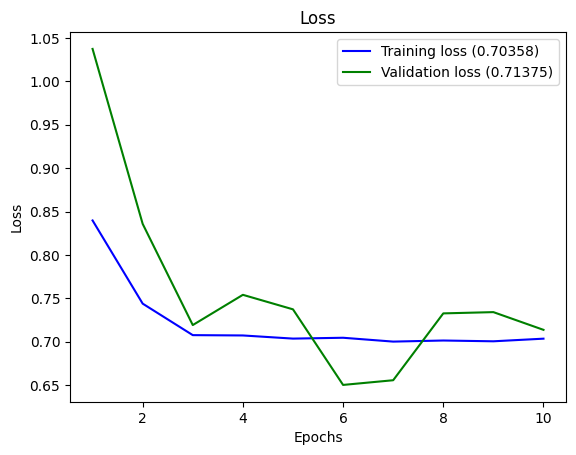

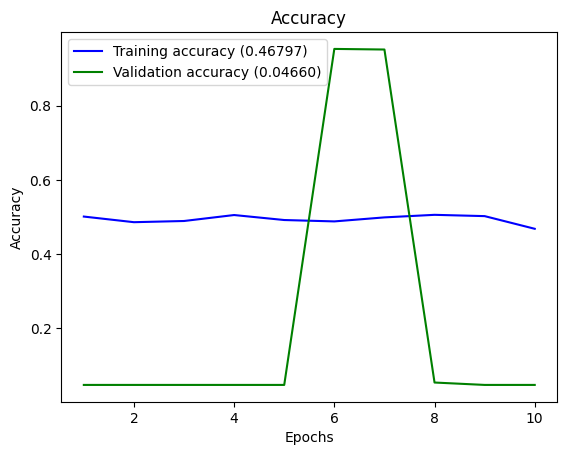

In [40]:
plot_history(his)